In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import pdb

import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]

import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from pikachu_dataset import load_data_pikachu
from torch import nn
from torch.utils.data import Dataset
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class PikachuDataset(Dataset):
    
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
    
        encoder = DataEncoder()
        if self.anchor_areas is not None:
            encoder.anchor_areas = self.anchor_areas  # p3 -> p7
            
        self.encoder = encoder 
        
    def __len__(self):
        return 900
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        # labels NOT one-hot encoded
       
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
def down_sample(in_channels,out_channels):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                 nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                  nn.MaxPool2d(2,2)
                 
                 )

class SimpleSSD(nn.Module):
    
    def __init__(self, n_cls=1, num_anchors=9):
        super(SimpleSSD, self).__init__()
        
        self.n_cls = n_cls
        self.num_anchors = num_anchors
        
        # Base CNN (think resnet/vgg or other base network)
        self.step1 = down_sample(3, 128)
        self.step2 = down_sample(128, 128)
        
        self.step3 = down_sample(128, 128)
        self.step4 = down_sample(128, 128)
        self.step5 = down_sample(128, 128)

        # assumes one-hot encoded classes
        self.cls_head1 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, self.num_anchors *4, 3, padding=1)
        
        # assumes one-hot encoded classes
        self.cls_head2 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head2 = nn.Conv2d(128,self.num_anchors * 4,3, padding=1)
        
        # assumes one-hot encoded classes
        self.cls_head3 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head3 = nn.Conv2d(128, self.num_anchors * 4,3, padding=1) 
        
    def forward(self, x):
        
        step1=self.step1(x)
        step2=self.step2(step1)

        step3=self.step3(step2)
        step4 = self.step4(step3)
        step5 = self.step5(step4)
        
        cls1 = self.cls_head1(step3)
        bbox1 = self.bbox_head1(step3)
        
        cls2 = self.cls_head2(step4)
        bbox2 = self.bbox_head2(step4)
        
        cls3 = self.cls_head3(step5)
        bbox3 = self.bbox_head3(step5)
        
        #pdb.set_trace()        
        
        # assumes one-hot encoded classes
        cls1 = cls1.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls2 = cls2.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls3 = cls3.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        
        bbox1 = bbox1.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox2 = bbox2.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox3 = bbox3.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
      
        cls_pred = torch.cat([cls1, cls2, cls3], dim=1)
        bbox_pred = torch.cat([bbox1, bbox2, bbox3], dim=1)
        
        return bbox_pred, cls_pred

In [3]:
pikachu_ds =PikachuDataset(anchor_areas=[8*8.,16*16.,32*32])
pikachu_dl = DataLoader(pikachu_ds, batch_size=2, collate_fn=pikachu_ds.collate_func)

# for b in pikachu_dl:
#     image, bounding_boxes, labels = b

In [4]:
model= SimpleSSD(1)
model = model.to(device)
criterion = FocalLoss(num_classes=1)

In [5]:
# Basically: (Focal) loss between ALL (non-ignored) ground-truth anchor boxes (class and delta for (xy, dims) for every
# coordinate within all feature maps) and corresponding predicted feature maps

import time
tic = time.time()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
collect = []
for epoch in range(10):
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
        print(total_loss)
        collect.append([total_loss.detach().cpu().numpy()])
        
toc = time.time()
print(f'Done after = {toc-tic:.3f}s')

/opt/conda/envs/dsr/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(3288.7974, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3250.0220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3202.7163, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3168.1848, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3161.9136, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3129.3730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3113.6912, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3055.1089, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3014.4065, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3013.4922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2999.1772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2956.4177, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2919.0159, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2909.0620, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2908.1924, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2829.5967, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2831.0139, device='cuda:0', grad_fn=<AddBackward0

tensor(1173.7234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1240.2787, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1320.7117, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1064.1611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1152.9440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1133.2106, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1043.1139, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1003.9206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1053.6874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1108.2104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(996.6066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(991.0040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(989.2697, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1013.4945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1118.2065, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1065.3513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(984.3510, device='cuda:0', grad_fn=<AddBackward0>)
t

tensor(520.8830, device='cuda:0', grad_fn=<AddBackward0>)
tensor(454.1917, device='cuda:0', grad_fn=<AddBackward0>)
tensor(578.0795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(476.2368, device='cuda:0', grad_fn=<AddBackward0>)
tensor(546.3199, device='cuda:0', grad_fn=<AddBackward0>)
tensor(505.1372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(441.6584, device='cuda:0', grad_fn=<AddBackward0>)
tensor(452.6261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(471.7595, device='cuda:0', grad_fn=<AddBackward0>)
tensor(429.1230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(440.7661, device='cuda:0', grad_fn=<AddBackward0>)
tensor(502.9839, device='cuda:0', grad_fn=<AddBackward0>)
tensor(449.1030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(528.2903, device='cuda:0', grad_fn=<AddBackward0>)
tensor(479.4890, device='cuda:0', grad_fn=<AddBackward0>)
tensor(451.2846, device='cuda:0', grad_fn=<AddBackward0>)
tensor(559.5786, device='cuda:0', grad_fn=<AddBackward0>)
tensor(498.573

tensor(420.0210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(268.4145, device='cuda:0', grad_fn=<AddBackward0>)
tensor(264.8499, device='cuda:0', grad_fn=<AddBackward0>)
tensor(246.0884, device='cuda:0', grad_fn=<AddBackward0>)
tensor(359.6170, device='cuda:0', grad_fn=<AddBackward0>)
tensor(242.6632, device='cuda:0', grad_fn=<AddBackward0>)
tensor(359.7628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(302.5200, device='cuda:0', grad_fn=<AddBackward0>)
tensor(282.6234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(315.6567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(395.4955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(229.8995, device='cuda:0', grad_fn=<AddBackward0>)
tensor(221.4254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(272.3139, device='cuda:0', grad_fn=<AddBackward0>)
tensor(273.2144, device='cuda:0', grad_fn=<AddBackward0>)
tensor(263.9989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(257.3422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(236.945

tensor(182.4926, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.9366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(162.8720, device='cuda:0', grad_fn=<AddBackward0>)
tensor(167.2536, device='cuda:0', grad_fn=<AddBackward0>)
tensor(168.4905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(282.9936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(165.9702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(155.1634, device='cuda:0', grad_fn=<AddBackward0>)
tensor(200.2193, device='cuda:0', grad_fn=<AddBackward0>)
tensor(174.0152, device='cuda:0', grad_fn=<AddBackward0>)
tensor(236.8335, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.3622, device='cuda:0', grad_fn=<AddBackward0>)
tensor(200.0167, device='cuda:0', grad_fn=<AddBackward0>)
tensor(130.8494, device='cuda:0', grad_fn=<AddBackward0>)
tensor(156.0215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(156.3563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(144.9557, device='cuda:0', grad_fn=<AddBackward0>)
tensor(145.810

tensor(111.4239, device='cuda:0', grad_fn=<AddBackward0>)
tensor(212.0896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(120.2433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(112.0705, device='cuda:0', grad_fn=<AddBackward0>)
tensor(124.0084, device='cuda:0', grad_fn=<AddBackward0>)
tensor(164.8614, device='cuda:0', grad_fn=<AddBackward0>)
tensor(103.5871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(141.4098, device='cuda:0', grad_fn=<AddBackward0>)
tensor(121.2436, device='cuda:0', grad_fn=<AddBackward0>)
tensor(113.8875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(108.1729, device='cuda:0', grad_fn=<AddBackward0>)
tensor(105.9301, device='cuda:0', grad_fn=<AddBackward0>)
tensor(113.0357, device='cuda:0', grad_fn=<AddBackward0>)
tensor(114.2455, device='cuda:0', grad_fn=<AddBackward0>)
tensor(124.4983, device='cuda:0', grad_fn=<AddBackward0>)
tensor(118.1256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(114.6147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(96.6402

tensor(130.2979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(85.4631, device='cuda:0', grad_fn=<AddBackward0>)
tensor(94.8185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(80.1023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(93.0842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(84.8911, device='cuda:0', grad_fn=<AddBackward0>)
tensor(92.0184, device='cuda:0', grad_fn=<AddBackward0>)
tensor(102.0898, device='cuda:0', grad_fn=<AddBackward0>)
tensor(100.1269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(93.6133, device='cuda:0', grad_fn=<AddBackward0>)
tensor(82.3913, device='cuda:0', grad_fn=<AddBackward0>)
tensor(83.5372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(256.4138, device='cuda:0', grad_fn=<AddBackward0>)
tensor(104.9957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(94.1038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72.7204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(81.6784, device='cuda:0', grad_fn=<AddBackward0>)
tensor(88.6015, device='cu

tensor(82.6855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58.5237, device='cuda:0', grad_fn=<AddBackward0>)
tensor(86.2819, device='cuda:0', grad_fn=<AddBackward0>)
tensor(85.0094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(84.7756, device='cuda:0', grad_fn=<AddBackward0>)
tensor(86.1253, device='cuda:0', grad_fn=<AddBackward0>)
tensor(79.1871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(89.0721, device='cuda:0', grad_fn=<AddBackward0>)
tensor(67.9332, device='cuda:0', grad_fn=<AddBackward0>)
tensor(61.4413, device='cuda:0', grad_fn=<AddBackward0>)
tensor(76.6409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(83.4207, device='cuda:0', grad_fn=<AddBackward0>)
tensor(68.6184, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72.9792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(96.3541, device='cuda:0', grad_fn=<AddBackward0>)
tensor(61.5719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(64.5981, device='cuda:0', grad_fn=<AddBackward0>)
tensor(156.2197, device='cuda:0

tensor(81.9530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(67.6281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58.6229, device='cuda:0', grad_fn=<AddBackward0>)
tensor(69.4122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(51.4234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(64.8670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(47.5826, device='cuda:0', grad_fn=<AddBackward0>)
tensor(62.9481, device='cuda:0', grad_fn=<AddBackward0>)
tensor(54.6851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(67.3737, device='cuda:0', grad_fn=<AddBackward0>)
tensor(61.4338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58.4267, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58.1739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(56.9812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(64.4435, device='cuda:0', grad_fn=<AddBackward0>)
tensor(49.3218, device='cuda:0', grad_fn=<AddBackward0>)
tensor(51.4207, device='cuda:0', grad_fn=<AddBackward0>)
tensor(57.3907, device='cuda:0'

tensor(42.9440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(51.2784, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.5330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.4563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.1291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(49.2976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(129.6158, device='cuda:0', grad_fn=<AddBackward0>)
tensor(47.2746, device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.9033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(59.5763, device='cuda:0', grad_fn=<AddBackward0>)
tensor(53.9611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(56.0539, device='cuda:0', grad_fn=<AddBackward0>)
tensor(59.3146, device='cuda:0', grad_fn=<AddBackward0>)
tensor(50.8323, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58.5664, device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.5836, device='cuda:0', grad_fn=<AddBackward0>)
tensor(55.4964, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.0831, device='cuda:0

tensor(64.2858, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72.2877, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.9615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.6709, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.0854, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.7229, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.7623, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.8791, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.6637, device='cuda:0', grad_fn=<AddBackward0>)
tensor(53.7864, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.7187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.2671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.1513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(63.1915, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.8541, device='cuda:0', grad_fn=<AddBackward0>)
tensor(66.8614, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.8880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(57.4724, device='cuda:0'

tensor(34.5929, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.3485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.0817, device='cuda:0', grad_fn=<AddBackward0>)
tensor(50.0166, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.1506, device='cuda:0', grad_fn=<AddBackward0>)
tensor(54.6738, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.8808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.5378, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.2772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.8733, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.4367, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.5893, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.2228, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.1314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(52.0225, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.4381, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.3126, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.0962, device='cuda:0'

tensor(34.3443, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.2219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(69.7609, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.6928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.5686, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.0477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.2950, device='cuda:0', grad_fn=<AddBackward0>)
tensor(40.1556, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.4966, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.7642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.9348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.3291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.0278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.5465, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.9021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.3123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.8696, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.9339, device='cuda:0'

tensor(34.9496, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.9343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.6275, device='cuda:0', grad_fn=<AddBackward0>)
tensor(51.5186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.6385, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.4654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.8880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.8402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(45.1665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.8734, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.9594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1680, device='cuda:0', grad_fn=<AddBackward0>)
tensor(53.5511, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.5735, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.8277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.1412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.8135, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.4915, device='cuda:0'

tensor(39.7154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.7016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.9071, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.8736, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.3369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.4306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.4727, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.5575, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.5561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.9215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.8716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.8102, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.0846, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.6989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.1062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.7133, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.9372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.7909, device='cuda:0'

tensor(41.0235, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.6907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.4848, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.3392, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.9483, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.6181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.6382, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.3856, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.8396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.0966, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.3321, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.0664, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.5700, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.9066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.0041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(54.2349, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.6535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.0765, device='cuda:0'

tensor(29.1376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(57.4499, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.8236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.3223, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4055, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.3041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.8635, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.9077, device='cuda:0', grad_fn=<AddBackward0>)
tensor(40.1774, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.9189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.5236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.9923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.5968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.2888, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.4581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.3228, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.3418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.4434, device='cuda:0'

tensor(24.0955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.7027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.3046, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.0896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.6314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.6742, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.2736, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.9238, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.2061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.2969, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.3832, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.6545, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.0814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.2540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.9133, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.4189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.2071, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.5836, device='cuda:0'

tensor(33.1965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.2030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.4369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.0915, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.7577, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.0320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.2204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.1393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.0698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.6869, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.1058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.2762, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.6723, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.3826, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.0460, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.0982, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.2818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.4872, device='cuda:0'

tensor(25.6955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.3943, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.1107, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.8215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.3939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.1462, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.6123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.7772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.0366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.8964, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.7461, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.4320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.0211, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.4002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.5498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.7790, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.9819, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.3827, device='cuda:0'

tensor(19.5063, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.3792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.8224, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.5842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.4826, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.9296, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.6978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.7026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.5338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.4963, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.9467, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.9235, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.1488, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.0862, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.5015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.2200, device='cuda:0'

tensor(15.0670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.4493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.5361, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.6471, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.7674, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.2785, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.3936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.4107, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.7027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.9956, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.5772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.9627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.4601, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.9728, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.5401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.7780, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.9608, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.6942, device='cuda:0'

tensor(13.0692, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.8311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.3491, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.8784, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.9439, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.9773, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.3110, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.0206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.9720, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.2667, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.4519, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.9928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.6496, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.8285, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.6738, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.8843, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.2333, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.8231, device='cuda:0'

tensor(19.7327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.7321, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.7308, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.5175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.3016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.9202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.3304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.3961, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.9967, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.0946, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.0842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.8937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.5794, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.5637, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.5072, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.1388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.2200, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.7056, device='cuda:0'

tensor(19.1531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.0186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.5630, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.6945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.7322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.6907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.1491, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.0839, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.3358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.9017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.7419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.4374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.9233, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.6885, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.4477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.5451, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.5948, device='cuda:0'

tensor(16.0507, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.2357, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.8227, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.4421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.6472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.3371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.7122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.4288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.1685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.8896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.8423, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.6324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1432, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.3537, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.1362, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.4340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.0198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.6608, device='cuda:0'

tensor(16.7411, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.3205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.0773, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.0908, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.0397, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.3669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.6847, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.8148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.6050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.6202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.1175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.7923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.1215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.1310, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.1485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.4253, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.0773, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.0787, device='cuda:0'

tensor(13.1049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.4453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.6906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.2085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.0742, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.3843, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.2669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.9162, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.1943, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.2697, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.4763, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.7684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.0396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.9058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.0359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.4671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.8685, device='cuda:0'

tensor(19.0058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.4254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1707, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.8896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.9355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.1032, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.4270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.4737, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.3048, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.3718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.0348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.4906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.5375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.0291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.2133, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.0270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.3114, device='cuda:0'

tensor(13.0536, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.3783, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2601, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.3730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.3519, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.5469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.0215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.6842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.2369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.5295, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.0676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.7546, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.4802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.6346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.6013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.5841, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.1045, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.3633, device='cuda:0',

tensor(12.9073, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.7460, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.5304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.4224, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.0779, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.8305, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.1331, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.4373, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.0209, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.8919, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.1823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.6466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.3354, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.4741, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.0949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.4851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.7006, device='cuda:0',

tensor(10.5646, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.3206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.7955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.8661, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.8489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.0186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.6174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.0090, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.6134, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.4391, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.0097, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.5596, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.2994, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.3592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.6182, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.6052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.6142, device='cuda:0'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f61901aca20>],
      dtype=object)

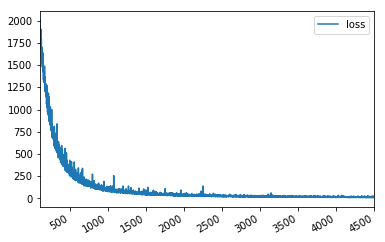

In [6]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float)[100:].plot(subplots=True)

# Visualize

failed in nnms


Text(0.5, 1.0, 'score tensor([0.6184], grad_fn=<IndexBackward>)')

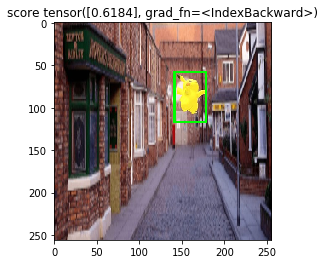

In [6]:
i = 0

bbspred, labelpred, score  = pikachu_ds.encoder.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

#pdb.set_trace()

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

### Exercises

-  Load a custom image with pikachu( or many ) and try to make predictiosn with the network and visualize the result
-  Can you think of anything that could confuse our detector? yellow dots ?
- Currently the code is not really modular, try to make it nice by splitting it into logical parts
    - Base feature extractor Module
    - Head Creator module
- Currently the detection/cls HEADS are very simple (just one CONV layer) they can be more complex. Try using more convolutions, check other architectures how its done

- Can you use our network to train using some new data for instance:
    - https://www.kaggle.com/tomluther/ships-in-google-earth
    - https://www.kaggle.com/aruchomu/data-for-yolo-v3-kernel
    - https://www.kaggle.com/dataturks/face-detection-in-images
    - https://www.kaggle.com/dataturks/face-dataset-with-age-emotion-ethnicity  
 You will need to create a data loader/data sets similar as we did for the pikachu loader. 


Original image size = (320, 213)
Resized image size = (385, 256)
Cropped image size = (256, 256)
Tensor size = torch.Size([1, 3, 256, 256])
failed in nnms


Text(0.5, 1.0, 'score tensor([0.4906], grad_fn=<IndexBackward>)')

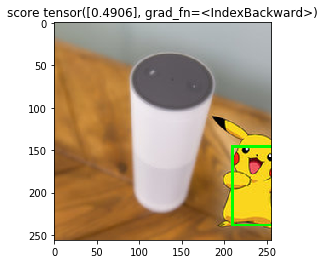

In [11]:
from PIL import Image
from random import randint
test_image = Image.open("pikachu3.jpg").convert("RGB")
print(f'Original image size = {test_image.size}')
if (np.array(test_image.size) < 256).any():
    resizing_factor = 256 / (test_image.size[np.argmin(np.array(test_image.size))])
    test_image = test_image.resize(
        (int(np.ceil(test_image.size[0] * resizing_factor)), int(np.ceil(test_image.size[1] * resizing_factor))), 
        Image.ANTIALIAS)
print(f'Resized image size = {test_image.size}')
top_crop    = randint(0, test_image.size[0] - 255)
left_crop   = randint(0, test_image.size[1] - 255)
bottom_crop = top_crop + 256
right_crop  = left_crop + 256
test_image = test_image.crop((top_crop, left_crop, bottom_crop, right_crop))
print(f'Cropped image size = {test_image.size}')
plt.imshow(test_image)
test_image = torch.Tensor(np.array(test_image) / 255)
test_image = test_image.permute(2,0,1).contiguous().unsqueeze(dim = 0).to(device)
print(f'Tensor size = {test_image.shape}')
loc_pred, cls_pred = model(test_image)

bbspred, labelpred, score  = pikachu_ds.encoder.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    test_image.squeeze().detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

The detector seem to have problems with multiple Pikachus and seems to detect only one per image. Maybe it was only trained on images containing one Pikachu? However, everything similar in appearance to Pikachus could probably yield false positives. Occluded Pikachus may even be not properly detected as well.